===================================================
### Code developed by: Vinicius Luiz Santos Silva

### Contact: v.santos-silva19@imperial.ac.uk
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName='WGAN-GP-training_4'
notebookName

'WGAN-GP-training_4'

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Constants


## Load data

In [6]:
# Mesh size
nl = 10
nc = 10
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [7]:
import joblib
#joblib.dump(pca_compress, "pca_compress_15.pkl") 
#np.savetxt('X_train_1D.csv', X_train_1D, delimiter=',') 
#np.savetxt('X_train_pca.csv', X_train_pca, delimiter=',') 
#np.savetxt('times.csv', times, delimiter=',') 
#with open('groups.txt','w') as f:
#    f.writelines([g + '\n' for g in groups])

#...
pca_compress = joblib.load("/content/drive/MyDrive/masters/small_dataset/pca_compress_15.pkl") 
X_train_compressed = np.loadtxt('/content/drive/MyDrive/masters/small_dataset/X_train_pca.csv', delimiter=',') 

X_train_1D = np.loadtxt('/content/drive/MyDrive/masters/small_dataset/X_train_1D.csv', delimiter=',') 
times  = np.loadtxt('/content/drive/MyDrive/masters/small_dataset/times.csv', delimiter=',') 
with open('/content/drive/MyDrive/masters/small_dataset/groups.txt') as f:
    groups = [g.strip() for g in f.readlines()]

# PCA recovered
X_recovered = pca_compress.inverse_transform(X_train_compressed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


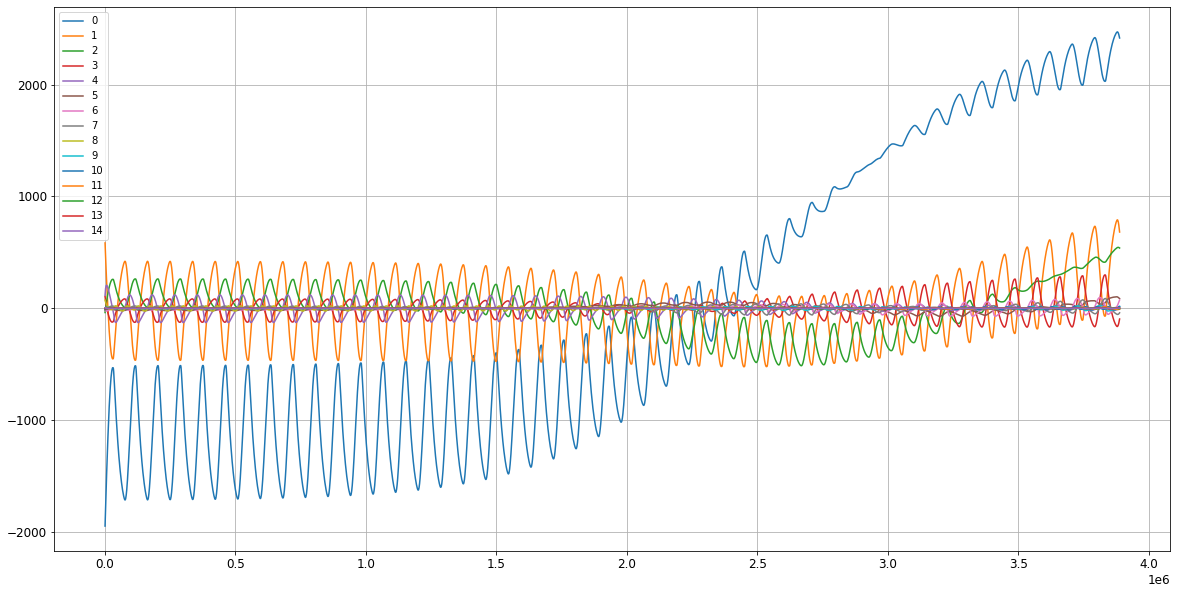

In [8]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times, X_train_compressed);
ax.grid()
ax.legend(range(15))

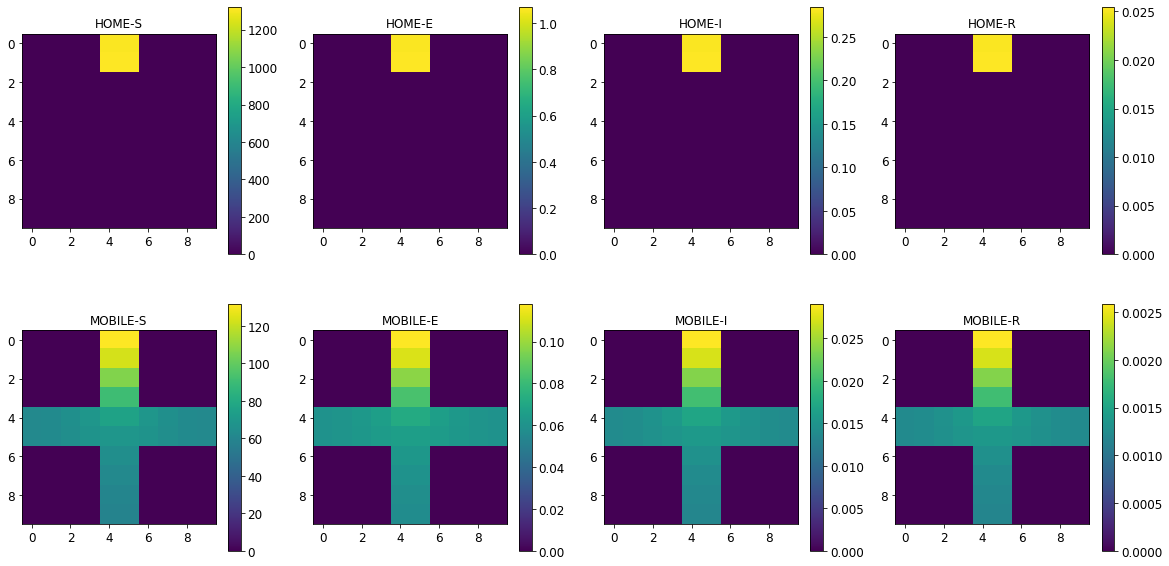

In [9]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

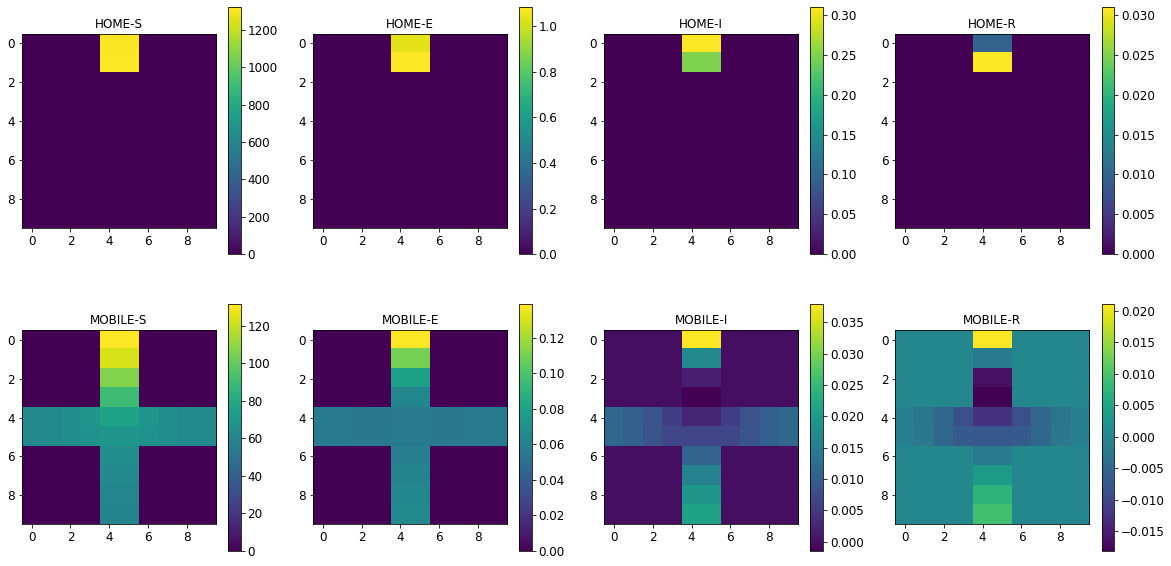

In [10]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_recovered.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

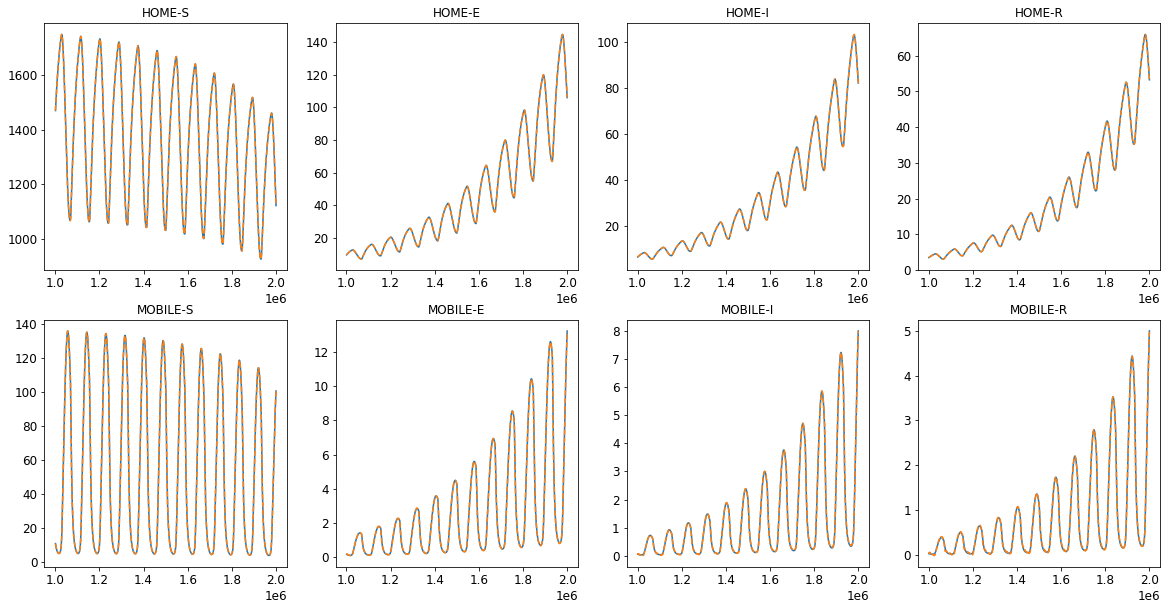

In [11]:


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times[1000:2000], X_train_1D[1000:2000,i*nl*nc+4])
    ax.flatten()[i].plot(times[1000:2000], X_recovered[1000:2000,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

## Prepare data

In [12]:
codings_size = X_train_compressed.shape[1]
X_train_compressed.shape

(3888, 15)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_compressed)*2 -1 
np.allclose(X_train_compressed, scaler.inverse_transform((X_train_scaled+1)/2))

True

In [14]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [15]:
ntimes = 9 # Consecutive times for the GAN
step = 10 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
print(X_train_concat.shape[0])
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )

3798


(3798, 9, 15)


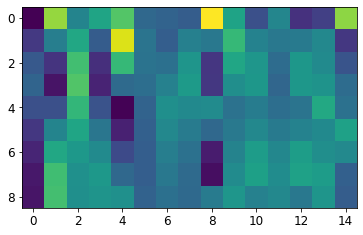

In [16]:
print(X_train_concat.shape)
plt.imshow(X_train_concat[0, :, :])

## Train the GAN

In [17]:
BATCH_SIZE = 256
latent_space = 100

# Create a tensorflow dataset and split it into batches
print(np.shape(X_train_concat))
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], 9, 15, 1).astype('float32')
print(np.shape(train_dataset))
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
print(len(X_train_concat))
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
print(type(train_dataset))
for data in train_dataset:
    print(data)
    break

(3798, 9, 15)
(3798, 9, 15, 1)
3798
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor(
[[[[-0.31804162]
   [-0.8826936 ]
   [ 0.35885724]
   ...
   [-0.01163714]
   [-0.061538  ]
   [-0.15159364]]

  [[-0.337717  ]
   [-0.82067436]
   [ 0.32863194]
   ...
   [-0.1117487 ]
   [ 0.367993  ]
   [-0.91490424]]

  [[-0.51161367]
   [-0.36424884]
   [ 0.13540721]
   ...
   [-0.12281659]
   [-0.22639634]
   [-0.00879957]]

  ...

  [[-0.7374083 ]
   [ 0.22245115]
   [-0.11062129]
   ...
   [-0.1300257 ]
   [ 0.03634453]
   [-0.21635702]]

  [[-0.56232655]
   [-0.23067664]
   [ 0.0738817 ]
   ...
   [-0.09716141]
   [-0.0519098 ]
   [-0.17052169]]

  [[-0.37747848]
   [-0.7029797 ]
   [ 0.26249894]
   ...
   [-0.03573894]
   [-0.07142767]
   [-0.15348482]]]


 [[[-0.67584395]
   [ 0.17695585]
   [-0.19114359]
   ...
   [-0.05773016]
   [ 0.11009907]
   [-0.1895777 ]]

  [[-0.507618  ]
   [-0.2686416 ]
   [ 0.0026339 ]
   ...
   [-0.06874871]
   [ 0.0322567 ]
   [-0.142630

In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(9*2*256, use_bias=False, input_shape=(latent_space,)))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((9, 2, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 2), padding='same', use_bias=False))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 2), padding='same', use_bias=False))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (5, 1), strides=(1, 2), padding='same', output_padding=[0,0], use_bias=False, activation='tanh'))

    return model

In [19]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4608)              460800    
_________________________________________________________________
layer_normalization (LayerNo (None, 4608)              9216      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4608)              0         
_________________________________________________________________
reshape (Reshape)            (None, 9, 2, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 4, 128)         294912    
_________________________________________________________________
layer_normalization_1 (Layer (None, 9, 4, 128)         256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 9, 4, 128)         0

(1, 9, 15, 1)


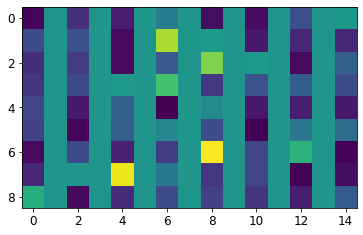

In [20]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

In [21]:
def make_critic_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[9, 15, 1]))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(1, 2), padding='same'))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    # could swap dropout and flatten layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [22]:
critic = make_critic_model()
critic.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 8, 64)          640       
_________________________________________________________________
layer_normalization_3 (Layer (None, 5, 8, 64)          128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 4, 128)         204928    
_________________________________________________________________
layer_normalization_4 (Layer (None, 5, 4, 128)         256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 4, 128)        

In [23]:
decision = critic(generated_image)
print (decision)

tf.Tensor([[-0.827681]], shape=(1, 1), dtype=float32)


In [24]:
#gan = keras.models.Sequential([generator, discriminator])
wgan = keras.models.Sequential([generator, critic])

In [25]:
# This method returns a helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

def critic_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss


# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
critic_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [26]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
critic_optimizer = tf.keras.optimizers.Adam(1e-4)
# generator_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
# critic_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [27]:
def gradient_penalty(real, fake):
    """
    WGAN-GP uses gradient penalty instead of the weight
    clipping to enforce the Lipschitz constraint.
    """

    # alpha = tf.random.normal([self.BATCH_SIZE, self.n_var], mean=0.0, stddev=0.1)
    if real.shape[0]==BATCH_SIZE:
        alpha = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
    else:
        alpha = tf.random.uniform(shape=[real.shape[0]%BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
    interpolated = real + alpha * (fake - real)
    # print('interpolated ', np.shape(interpolated))

    with tf.GradientTape() as t:
        t.watch(interpolated)
        pred = critic(interpolated, training=True)
        # print('pred', np.shape(pred))
    grad = t.gradient(pred, interpolated)
    gradient_norm = tf.norm(grad)
    gp = tf.reduce_mean((gradient_norm - 1)**2)
    return gp
    # print('grad', np.shape(grad))
    # print('tf.square(grad)', tf.shape(tf.square(grad)))
    # print('tf.reduce_sum(tf.square(grad)', tf.shape(tf.reduce_sum(tf.square(grad))))
    # print('tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)', tf.shape(tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)))
    # norm = tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)
    # print('norm', tf.shape(norm))


In [28]:
# We will reuse this seed overtime 
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [29]:
# logs to follow losses on tensorboard
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/' + 'WGAN-GP_4' + '/generator'
critic_log_dir = './logs/' + 'WGAN-GP_4' + '/critic'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
critic_summary_writer = tf.summary.create_file_writer(critic_log_dir)

In [30]:
@tf.function
def train_G(batch):
    """
    The training routine for the generator
    """
    if batch.shape[0]==BATCH_SIZE:
        noise = tf.random.normal([BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)
    else:
        noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)

    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise, training=True)
        fake_output = critic(generated_data, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # return tf.math.abs(gen_loss)
    # print('gen_loss', tf.shape(gen_loss))
    return gen_loss

In [31]:

@tf.function
def train_D(batch):
    """
    The training routine for the critic
    """
    if batch.shape[0]==BATCH_SIZE:
        noise = tf.random.normal([BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)
    else:
        noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)

    with tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = critic(batch, training=True)
        fake_output = critic(generated_data, training=True)

        disc_loss = critic_loss(real_output, fake_output)
        gp = gradient_penalty(batch, generated_data)
        # disc_loss += (self.critic_loss(real_output, fake_output) + gp*10.0)
        disc_loss += gp*10.0

    gradients_of_critic = disc_tape.gradient(disc_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))

    # return tf.math.abs(disc_loss)
    # print('disc_loss', tf.shape(disc_loss))
    # print('disc_slice', tf.slice(disc_loss, [0], [-1]))
    

    return disc_loss

In [32]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
# def train_step(batch):
#     noise = tf.random.normal([BATCH_SIZE, latent_space])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         generated_images = generator(noise, training=True)

#         real_output = discriminator(batch, training=True)
#         fake_output = discriminator(generated_images, training=True)

#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
#     generator_mean_loss(gen_loss)
#     discriminator_mean_loss(disc_loss)


In [33]:
# test_count = 0
# def test_f(test_count):
#   print('done')
#   test_count += 1
#   return test_count

# def train_test(test_count, epochs=10):
#   for epoch in range(epochs):
#     test_f(test_count)
#     test_count = test_f(test_count)
#     print(test_count)
    
#   return 1

# bla = train_test(test_count)




In [34]:
# def train(dataset, epochs, scaler, scaled, X_train, y_train,n_critic=5):
def train(dataset, epochs, n_critic=5):
    """
    Training the WGAN-GP
    """

    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch, epochs))

        for batch in dataset:

            for _ in range(n_critic):
              # train_D(batch, count_D)
              disc_loss = train_D(batch)
            critic_mean_loss(disc_loss)
            # print('critic_mean_loss', critic_mean_loss.numpy())

            


            gen_loss = train_G(batch)
            generator_mean_loss(gen_loss)
            # train_G(batch, count_G)

        with critic_summary_writer.as_default():
              tf.summary.scalar('loss', critic_mean_loss.result(), step=epoch)

        with generator_summary_writer.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        # with critic_summary_writer.as_default():
        #     tf.summary.scalar('loss', critic_mean_loss.result(), step=epoch)

        hist.append([generator_mean_loss.result().numpy(), critic_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        critic_mean_loss.reset_states()

        # print("critic", "{}: {:.6f}".format(critic.metrics_names[0], hist[-1][1]), end=' - ')
        # print("generator", "{}: {:.6f}".format(wgan.metrics_names[0], hist[-1][0]), end=' - ')    
        # print ('{:.0f}s'.format( time.time()-start))

        print("critic: {:.6f}".format(hist[-1][1]), end=' - ')
        print("generator: {:.6f}".format(hist[-1][0]), end=' - ')
        print('{:.0f}s'.format( time.time()-start))

        print('disc_numpy', disc_loss.numpy())
        print('gen_numpy', gen_loss.numpy())
        # Global variables are used below
        if epoch%1000 == 0: 
            # Plot generated data
            X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
            X_generated = pca_compress.inverse_transform(X_generated)
            X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
            fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
            for j in range(num_examples_to_generate):
                for i, group in enumerate(groups):
                    for k in range(0,10,10): 
                        ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
                for i, group in enumerate(groups):
                    im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
                    fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
            plt.savefig('snapshot_images/town/'+'WGAN-GP_5_'+str(epoch)+'.jpeg')
            plt.show() 
            

            # Save model
            wgan.save('ganmodels/'+'WGAN-GP_5_'+str(epoch)+'.h5')
                        
    

            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist[100:])
            ax.legend(['loss_gen', 'loss_disc'])
            # ax.set_yscale('log')
            ax.grid()
            plt.savefig('snapshot_images/loss/'+'WGAN-GP_5_'+str(epoch)+'.jpeg')
            plt.show()

    return hist


In [35]:
# def train(dataset, epochs):
#     hist = []
#     for epoch in range(epochs):
#         start = time.time()
#         print("Epoch {}/{}".format(epoch + 1, epochs))   

#         for batch in dataset:
#             train_step(batch)
            
#         with generator_summary_writer.as_default():
#             tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

#         with discriminator_summary_writer.as_default():
#             tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
#         hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

#         generator_mean_loss.reset_states()
#         discriminator_mean_loss.reset_states()
        
#         print("discriminator", "{}: {:.6f}".format(discriminator.metrics_names[0], hist[-1][1]), end=' - ')
#         print("generator", "{}: {:.6f}".format(gan.metrics_names[0], hist[-1][0]), end=' - ')    
#         print ('{:.0f}s'.format( time.time()-start))

#         # Global variables are used below
#         if epoch%1000 == 0: 
#             # Plot generated data
#             X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
#             X_generated = pca_compress.inverse_transform(X_generated)
#             X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
#             fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
#             for j in range(num_examples_to_generate):
#                 for i, group in enumerate(groups):
#                     for k in range(0,10,10): 
#                         ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
#                 for i, group in enumerate(groups):
#                     im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
#                     fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
#             plt.show() 
                    
#             # Save model
#             gan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    
            
#             # plot loss
#             print('Loss: ')
#             fig, ax = plt.subplots(1,1, figsize=[20,10])
#             ax.plot(hist)
#             ax.legend(['loss_gen', 'loss_disc'])
#             ax.set_yscale('log')
#             ax.grid()
#             plt.show()
            
#     return hist


Epoch 0/10000
critic: 12689.168945 - generator: 0.613018 - 7s
disc_numpy 2882.9438
gen_numpy 0.60609937


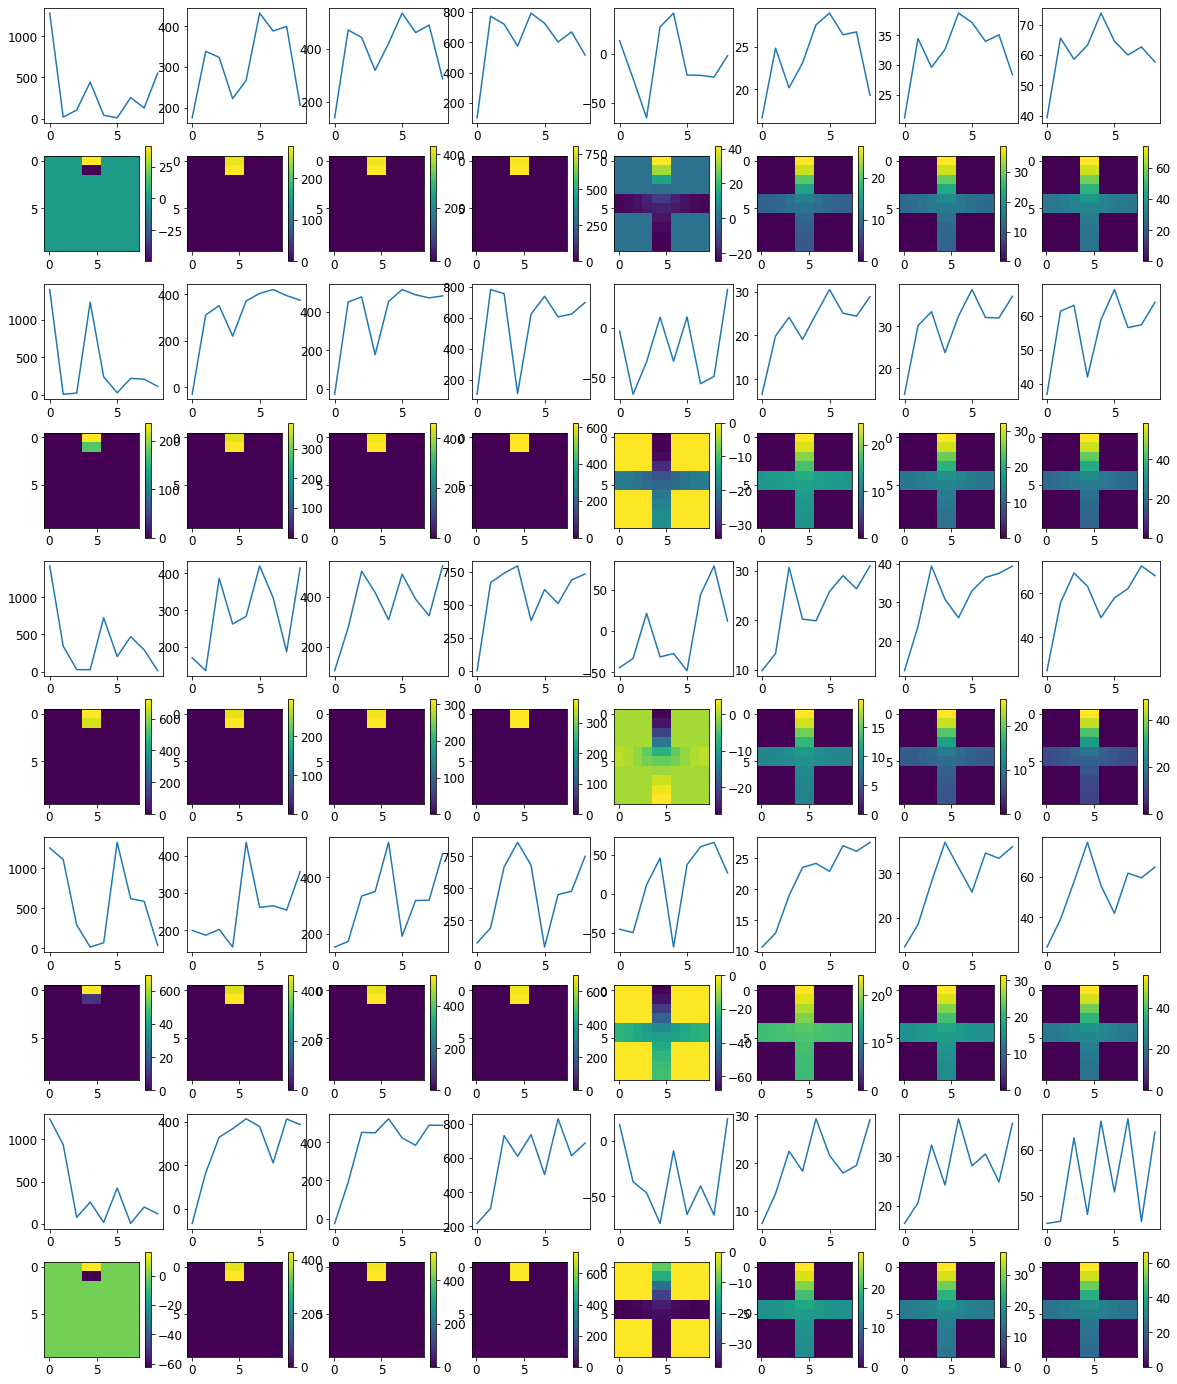

Loss: 


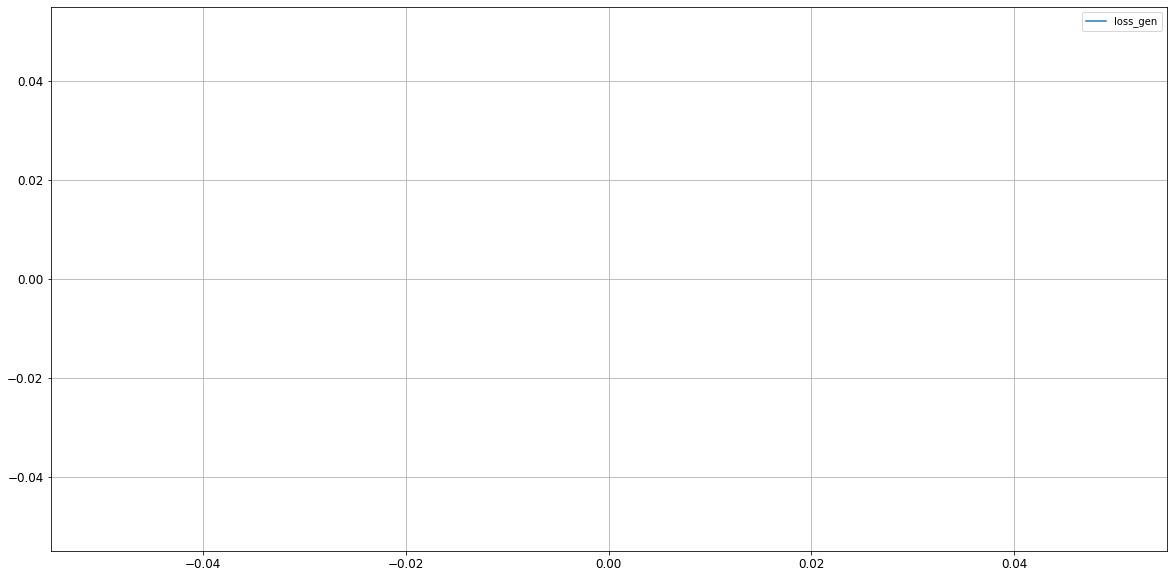

Epoch 1/10000
critic: 2020.963623 - generator: 0.593123 - 2s
disc_numpy 1261.0775
gen_numpy 0.5363982
Epoch 2/10000
critic: 1192.254517 - generator: 0.511832 - 2s
disc_numpy 895.1492
gen_numpy 0.45268542
Epoch 3/10000
critic: 870.490662 - generator: 0.409304 - 2s
disc_numpy 568.5603
gen_numpy 0.3296629
Epoch 4/10000
critic: 626.341064 - generator: 0.345467 - 2s
disc_numpy 430.9641
gen_numpy 0.31915882
Epoch 5/10000
critic: 420.966461 - generator: 0.298574 - 2s
disc_numpy 283.17938
gen_numpy 0.2827027
Epoch 6/10000
critic: 323.913208 - generator: 0.266167 - 2s
disc_numpy 228.61017
gen_numpy 0.31985542
Epoch 7/10000
critic: 256.375214 - generator: 0.239738 - 2s
disc_numpy 194.28612
gen_numpy 0.21521695
Epoch 8/10000
critic: 206.358047 - generator: 0.232936 - 2s
disc_numpy 154.56288
gen_numpy 0.19665344
Epoch 9/10000
critic: 172.744247 - generator: 0.214807 - 2s
disc_numpy 119.17801
gen_numpy 0.20035686
Epoch 10/10000
critic: 141.449158 - generator: 0.220497 - 2s
disc_numpy 101.79954
gen_

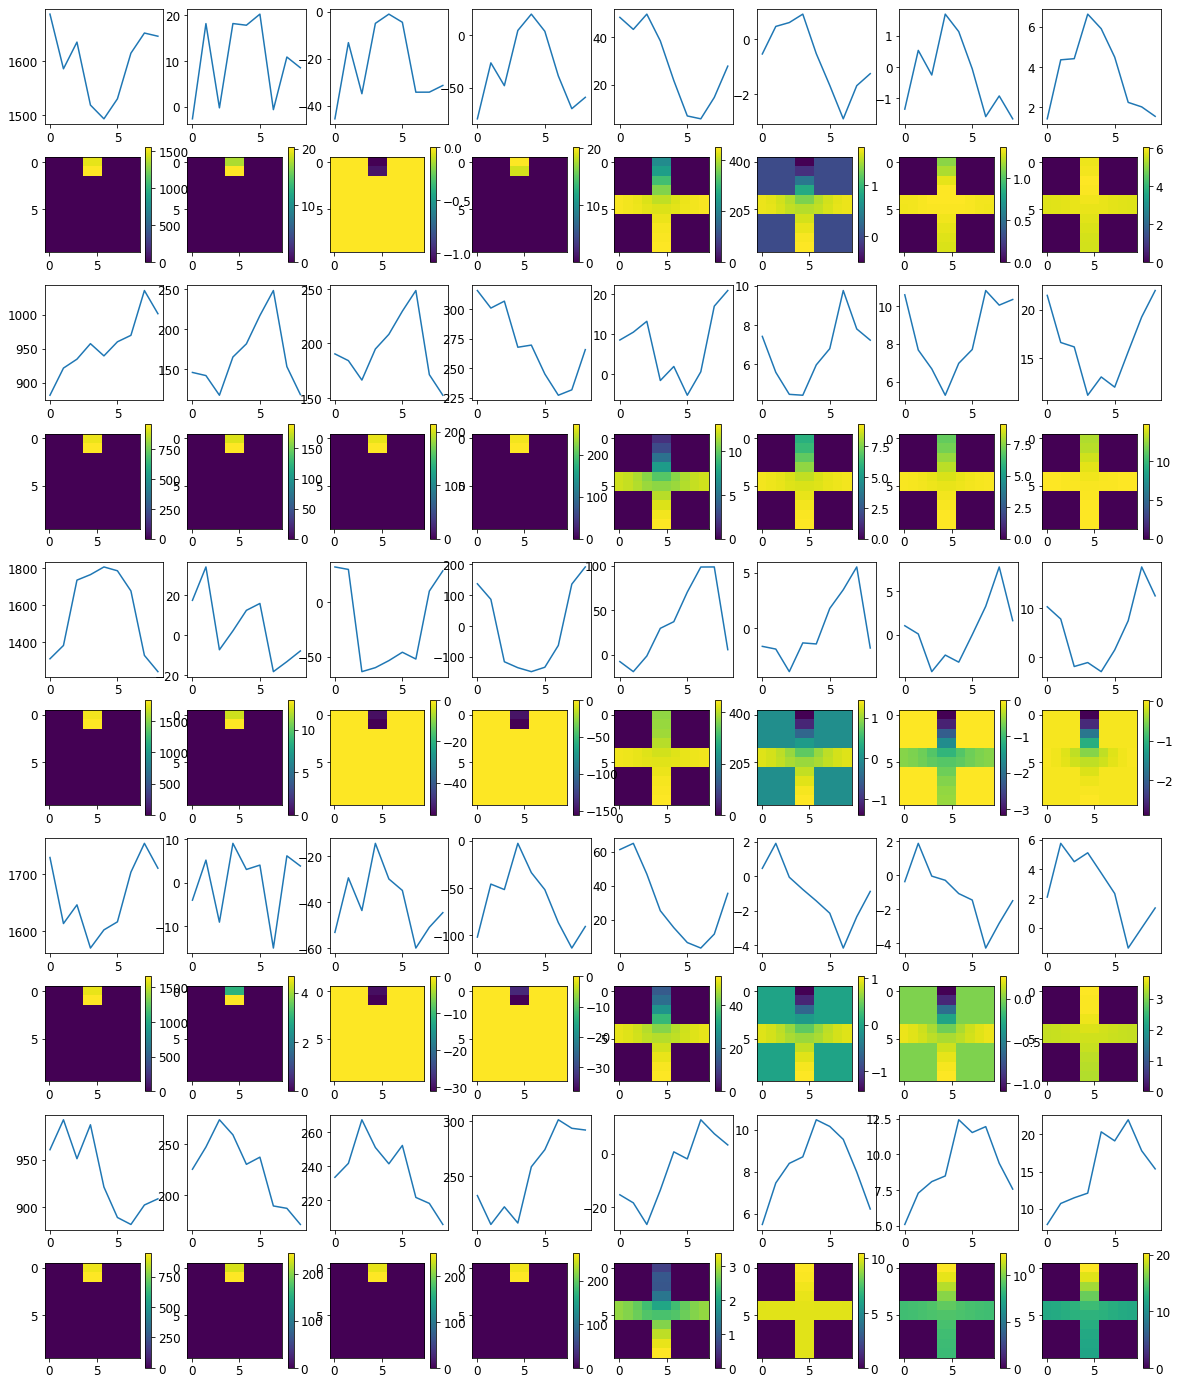

Loss: 


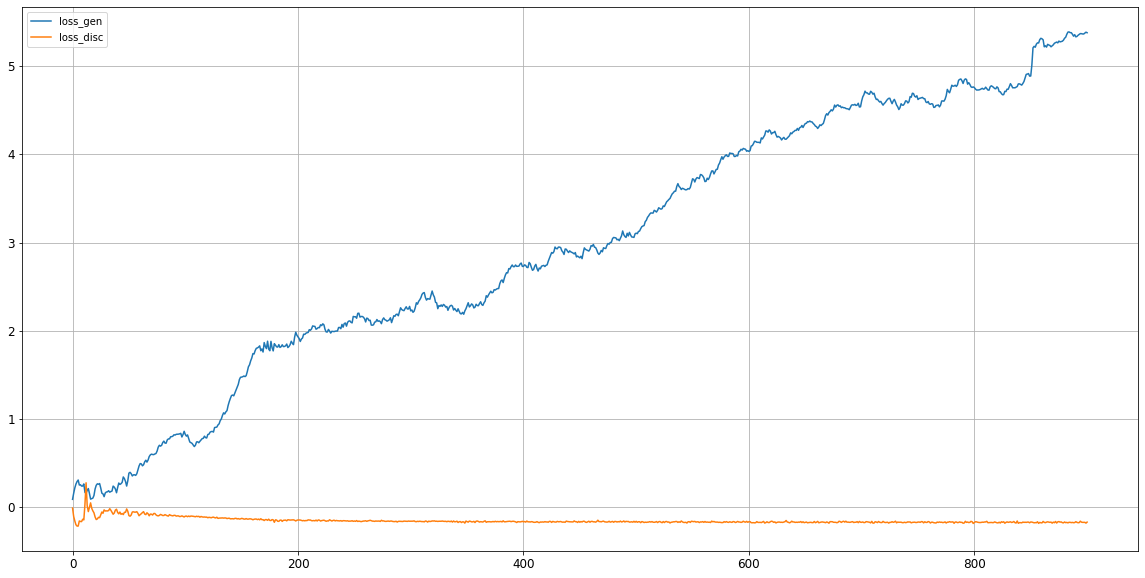

Epoch 1001/10000
critic: -0.173854 - generator: 5.410064 - 2s
disc_numpy -0.19227268
gen_numpy 5.4045005
Epoch 1002/10000
critic: -0.177818 - generator: 5.395935 - 2s
disc_numpy -0.17220621
gen_numpy 5.3838367
Epoch 1003/10000
critic: -0.173405 - generator: 5.395612 - 2s
disc_numpy -0.18797132
gen_numpy 5.4331355
Epoch 1004/10000
critic: -0.177310 - generator: 5.374673 - 2s
disc_numpy -0.15605891
gen_numpy 5.367674
Epoch 1005/10000
critic: -0.174555 - generator: 5.351517 - 3s
disc_numpy -0.15376331
gen_numpy 5.3493004
Epoch 1006/10000
critic: -0.179558 - generator: 5.351161 - 2s
disc_numpy -0.14812545
gen_numpy 5.348456
Epoch 1007/10000
critic: -0.171899 - generator: 5.343157 - 2s
disc_numpy -0.16197482
gen_numpy 5.3218017
Epoch 1008/10000
critic: -0.176590 - generator: 5.360301 - 2s
disc_numpy -0.18106444
gen_numpy 5.3472147
Epoch 1009/10000
critic: -0.172329 - generator: 5.356277 - 2s
disc_numpy -0.22641888
gen_numpy 5.341838
Epoch 1010/10000
critic: -0.173911 - generator: 5.366590 -

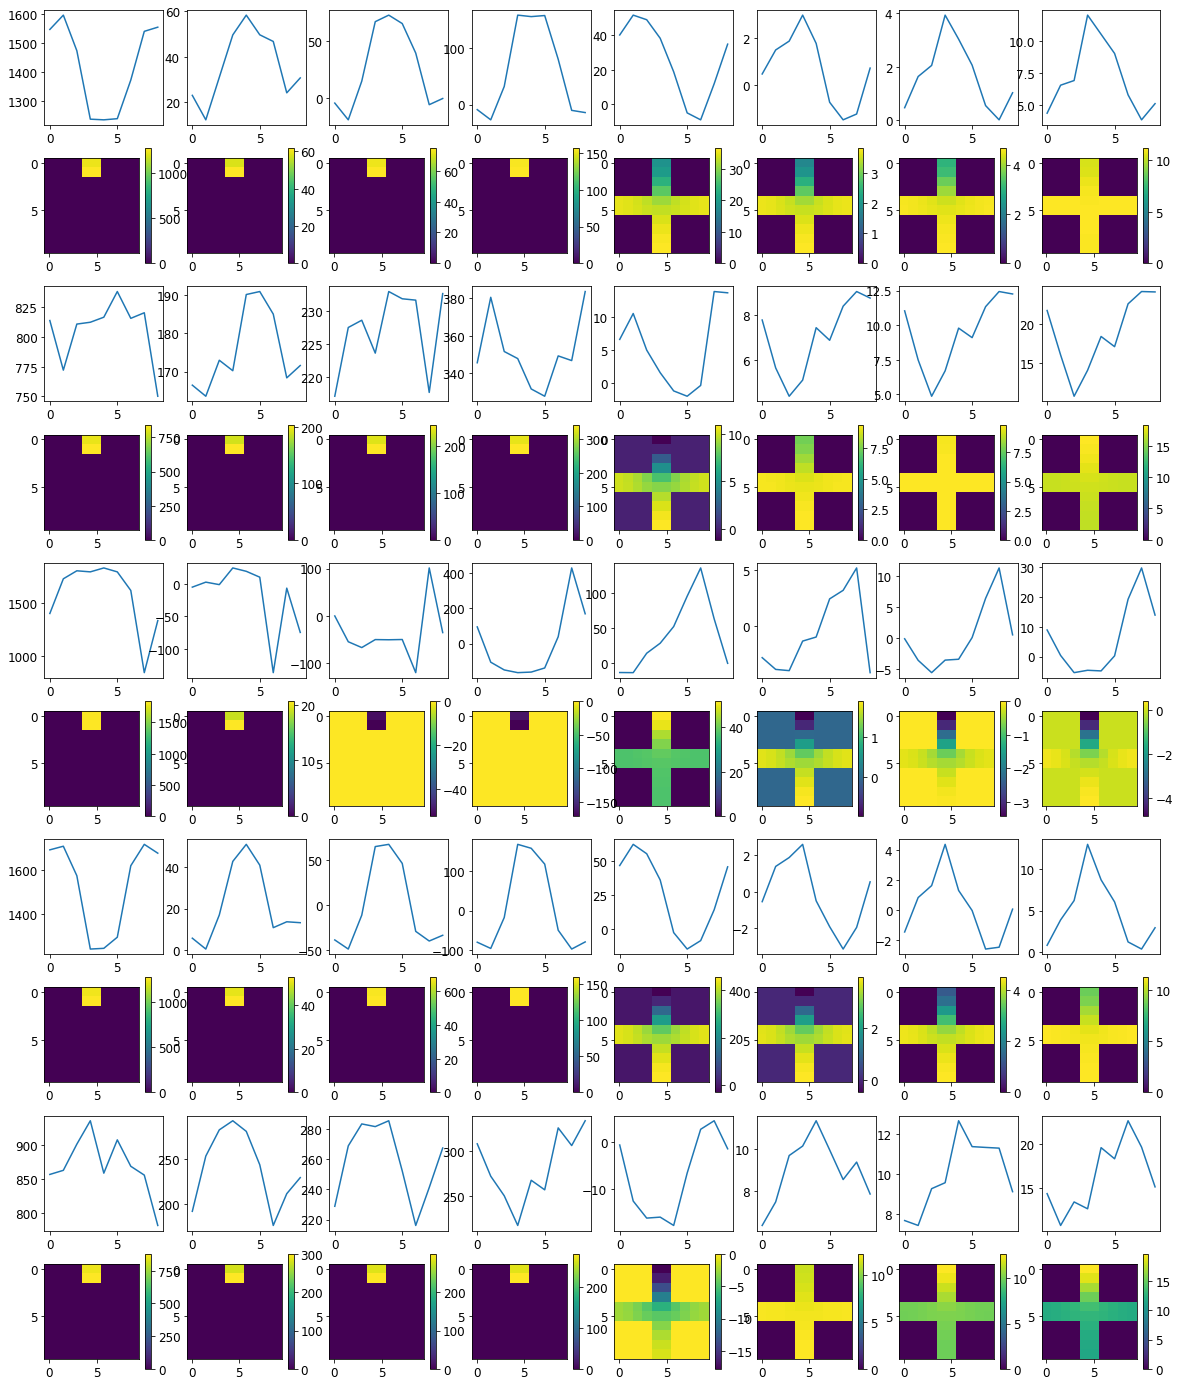

Loss: 


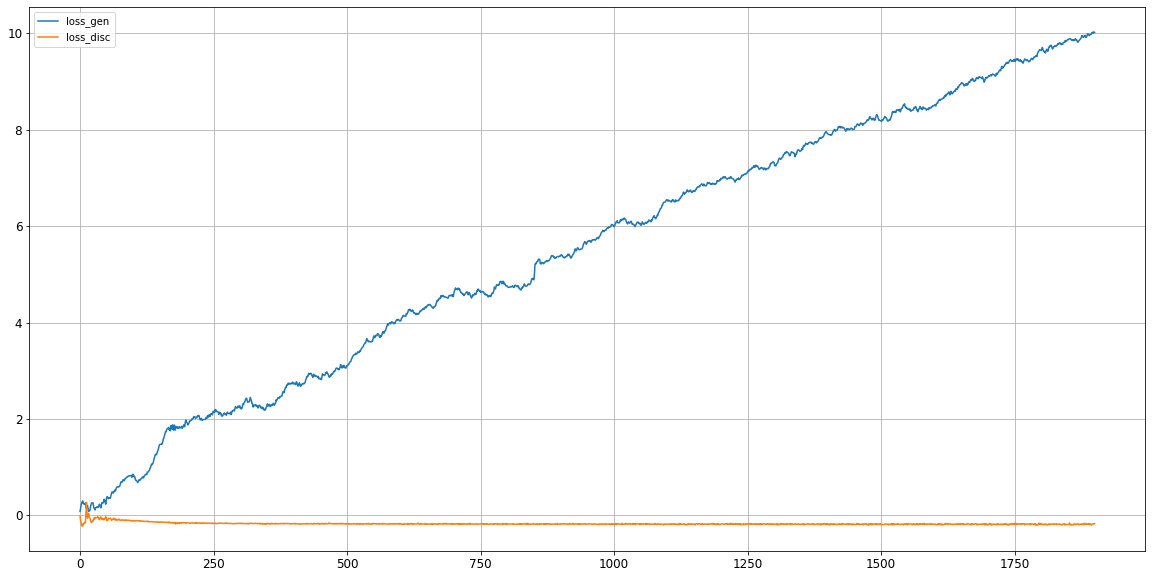

Epoch 2001/10000
critic: -0.175678 - generator: 10.013564 - 2s
disc_numpy -0.16339064
gen_numpy 10.050298
Epoch 2002/10000
critic: -0.174003 - generator: 10.006337 - 2s
disc_numpy -0.18297675
gen_numpy 10.050872
Epoch 2003/10000
critic: -0.190642 - generator: 10.041537 - 2s
disc_numpy -0.24103098
gen_numpy 10.104741
Epoch 2004/10000
critic: -0.174047 - generator: 10.092571 - 2s
disc_numpy -0.15234509
gen_numpy 10.124638
Epoch 2005/10000
critic: -0.187823 - generator: 10.084311 - 2s
disc_numpy -0.22956346
gen_numpy 10.159999
Epoch 2006/10000
critic: -0.171246 - generator: 10.126772 - 2s
disc_numpy -0.16510072
gen_numpy 10.177922
Epoch 2007/10000
critic: -0.184300 - generator: 10.117748 - 2s
disc_numpy -0.18641515
gen_numpy 10.159773
Epoch 2008/10000
critic: -0.193532 - generator: 10.085966 - 2s
disc_numpy -0.18237844
gen_numpy 10.097992
Epoch 2009/10000
critic: -0.167715 - generator: 10.095231 - 2s
disc_numpy -0.18683909
gen_numpy 10.110352
Epoch 2010/10000
critic: -0.192215 - generator

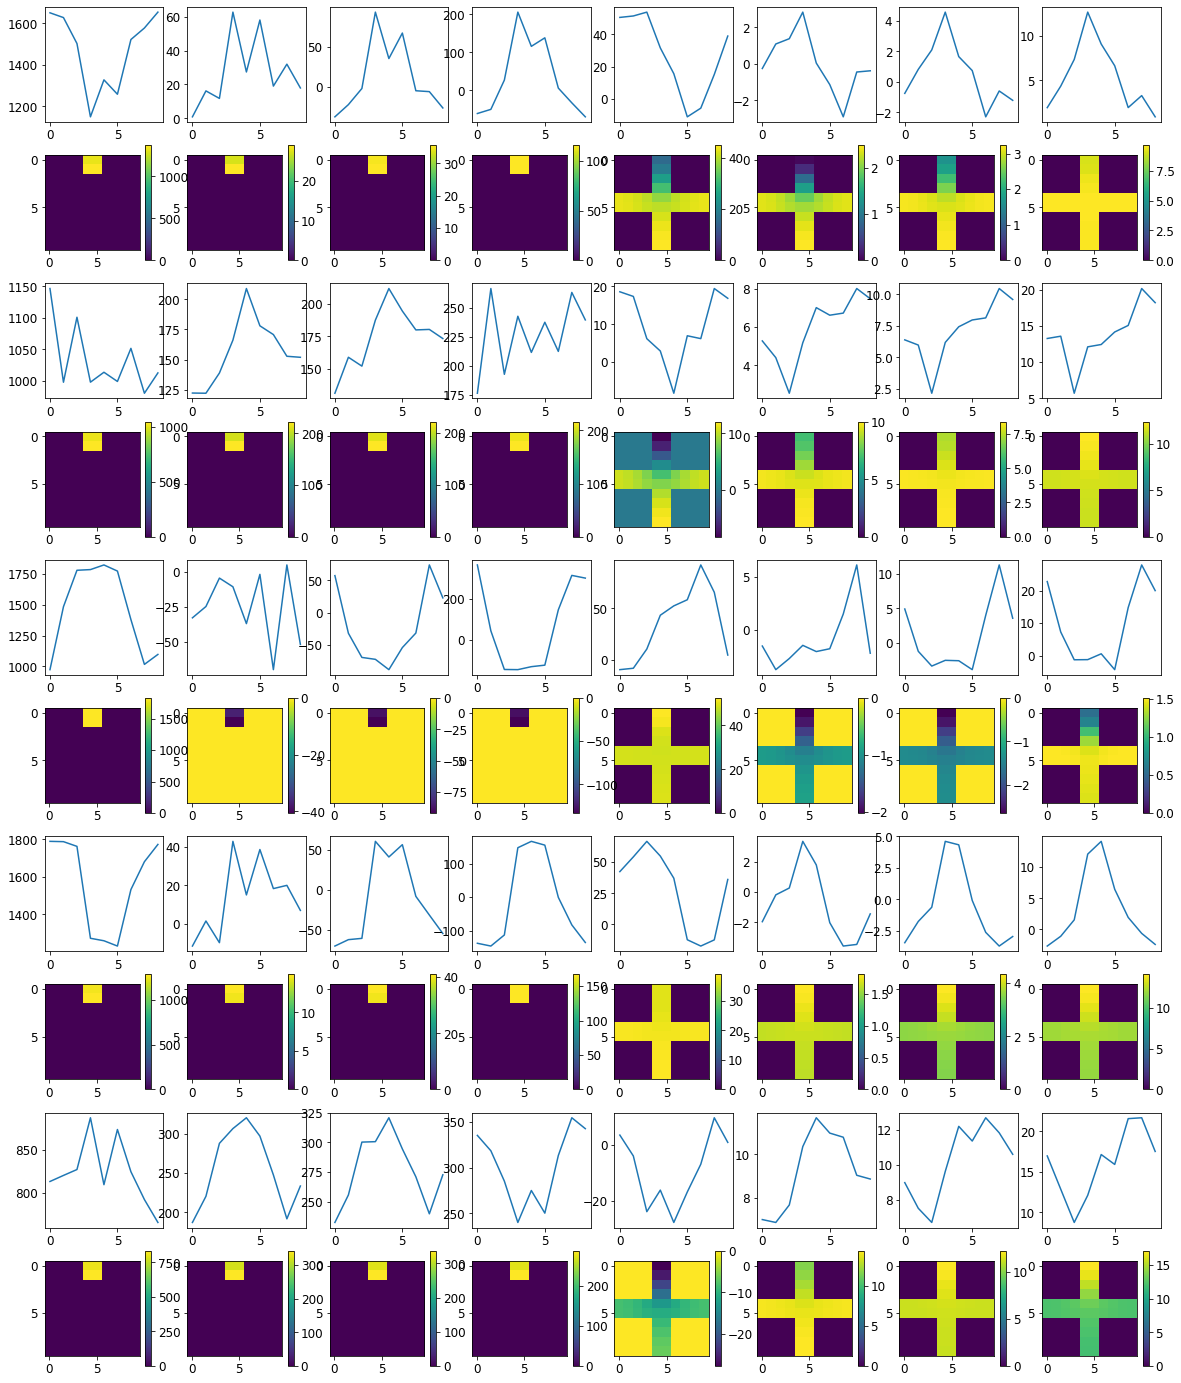

Loss: 


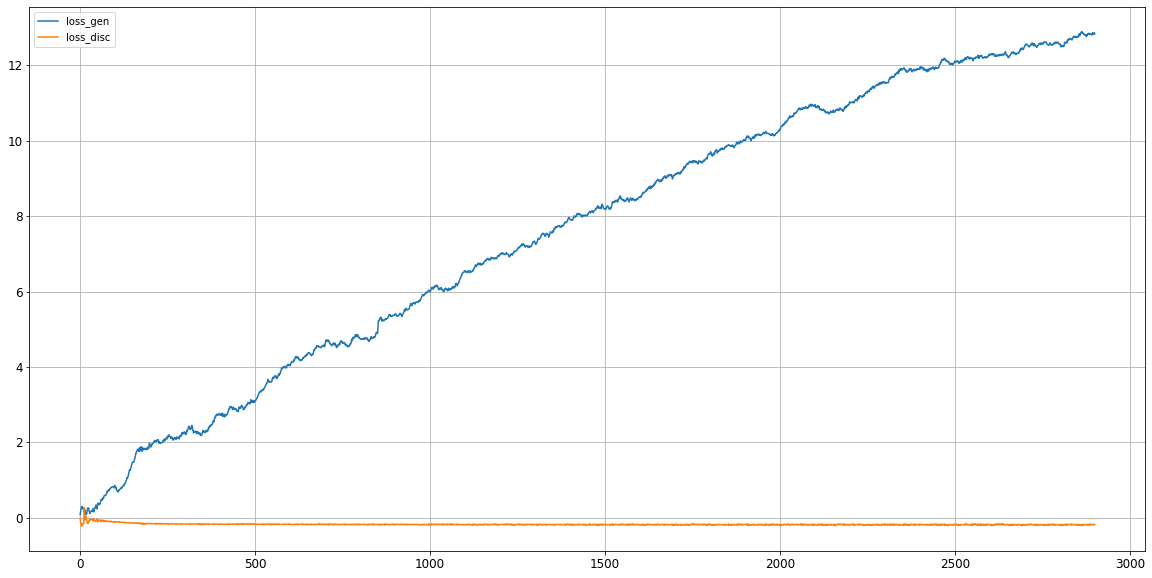

Epoch 3001/10000
critic: -0.188349 - generator: 12.886580 - 2s
disc_numpy -0.1383034
gen_numpy 12.958793
Epoch 3002/10000
critic: -0.184709 - generator: 12.856781 - 2s
disc_numpy -0.18918523
gen_numpy 12.884785
Epoch 3003/10000
critic: -0.160817 - generator: 12.834922 - 2s
disc_numpy -0.06120576
gen_numpy 12.90286
Epoch 3004/10000
critic: -0.174048 - generator: 12.842237 - 2s
disc_numpy -0.21031731
gen_numpy 12.94345
Epoch 3005/10000
critic: -0.184697 - generator: 12.848818 - 2s
disc_numpy -0.10958584
gen_numpy 12.90065
Epoch 3006/10000
critic: -0.185147 - generator: 12.824711 - 2s
disc_numpy -0.13454428
gen_numpy 12.826398
Epoch 3007/10000
critic: -0.194222 - generator: 12.817524 - 2s
disc_numpy -0.20532745
gen_numpy 12.885395
Epoch 3008/10000
critic: -0.179744 - generator: 12.805349 - 2s
disc_numpy -0.15758322
gen_numpy 12.840076
Epoch 3009/10000
critic: -0.178099 - generator: 12.839174 - 2s
disc_numpy -0.19693254
gen_numpy 12.93034
Epoch 3010/10000
critic: -0.192664 - generator: 12.

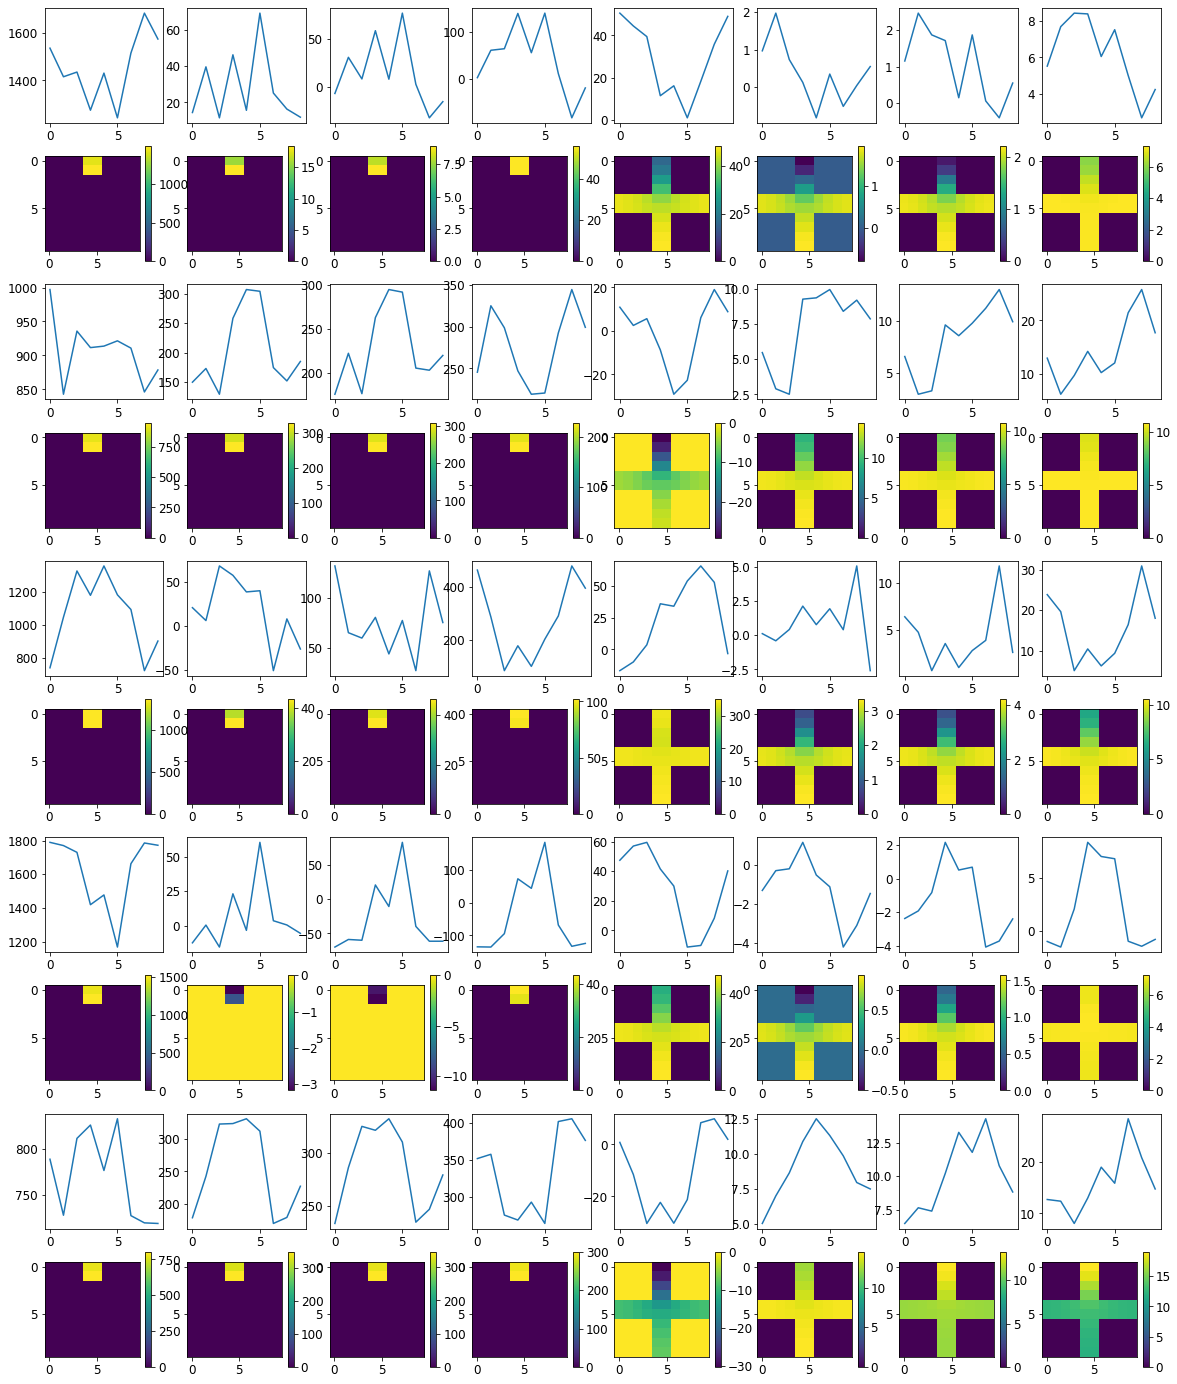

Loss: 


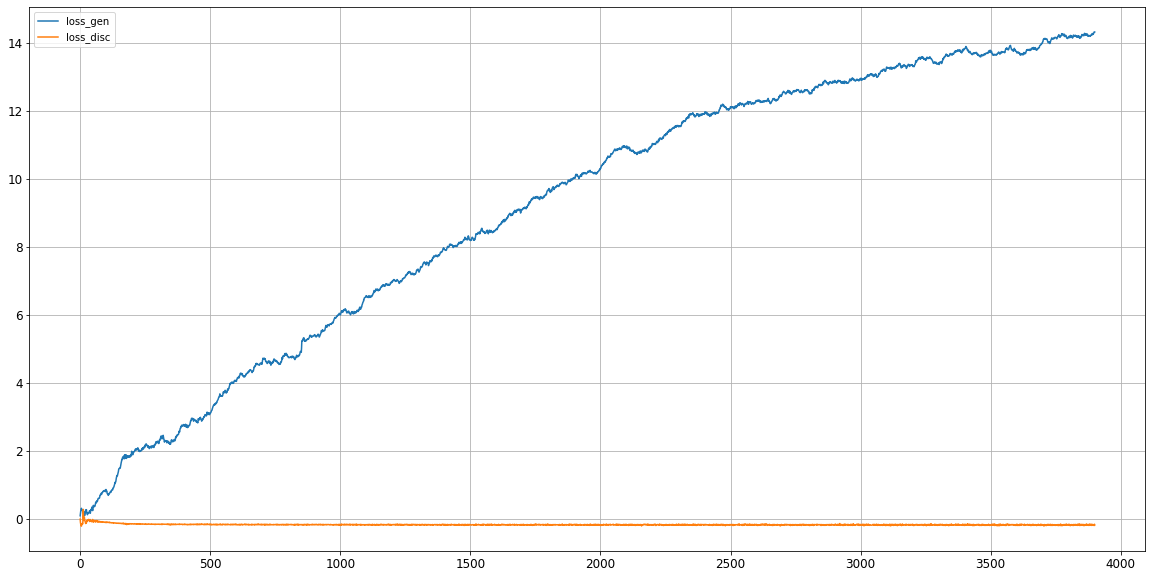

Epoch 4001/10000
critic: -0.192886 - generator: 14.307366 - 2s
disc_numpy -0.19406185
gen_numpy 14.377902
Epoch 4002/10000
critic: -0.196629 - generator: 14.270727 - 2s
disc_numpy -0.084006555
gen_numpy 14.302257
Epoch 4003/10000
critic: -0.185662 - generator: 14.279593 - 2s
disc_numpy -0.17258161
gen_numpy 14.337453
Epoch 4004/10000
critic: -0.196466 - generator: 14.241472 - 2s
disc_numpy -0.19620696
gen_numpy 14.298044
Epoch 4005/10000
critic: -0.222173 - generator: 14.248196 - 2s
disc_numpy -0.10240722
gen_numpy 14.308207
Epoch 4006/10000
critic: -0.188485 - generator: 14.231939 - 2s
disc_numpy -0.18775241
gen_numpy 14.269935
Epoch 4007/10000
critic: -0.200833 - generator: 14.233755 - 2s
disc_numpy -0.18834534
gen_numpy 14.268128
Epoch 4008/10000
critic: -0.196670 - generator: 14.221784 - 2s
disc_numpy -0.15874821
gen_numpy 14.240171
Epoch 4009/10000
critic: -0.187768 - generator: 14.243131 - 2s
disc_numpy -0.1782209
gen_numpy 14.258451
Epoch 4010/10000
critic: -0.207807 - generator

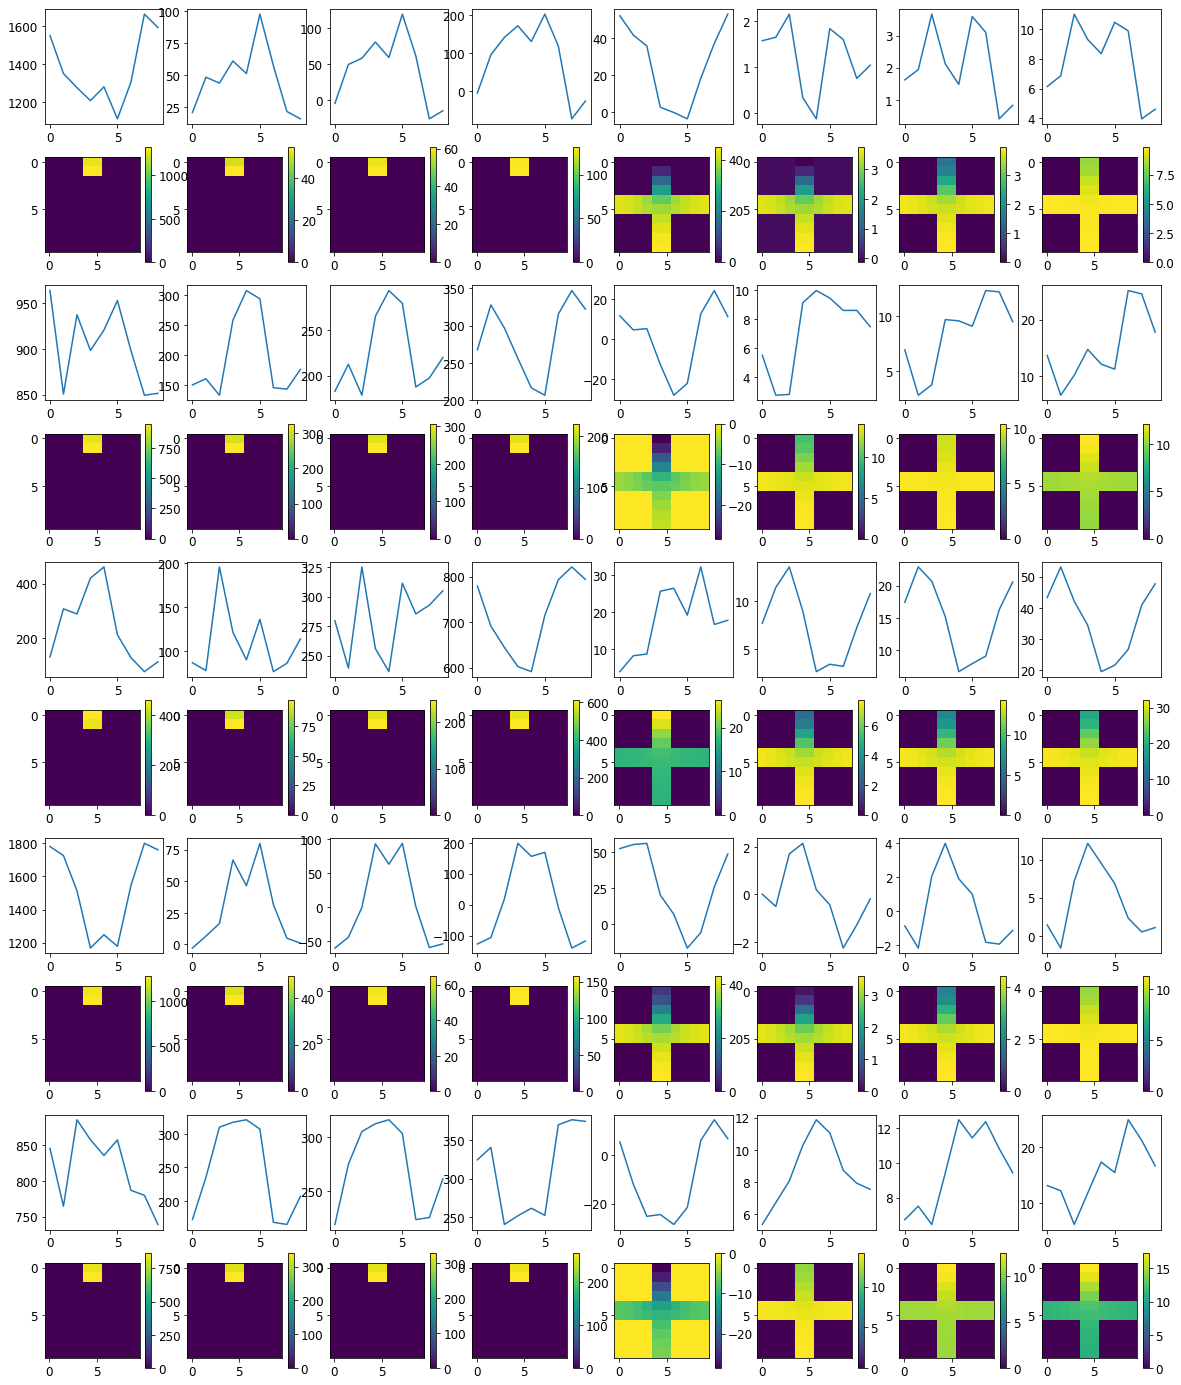

Loss: 


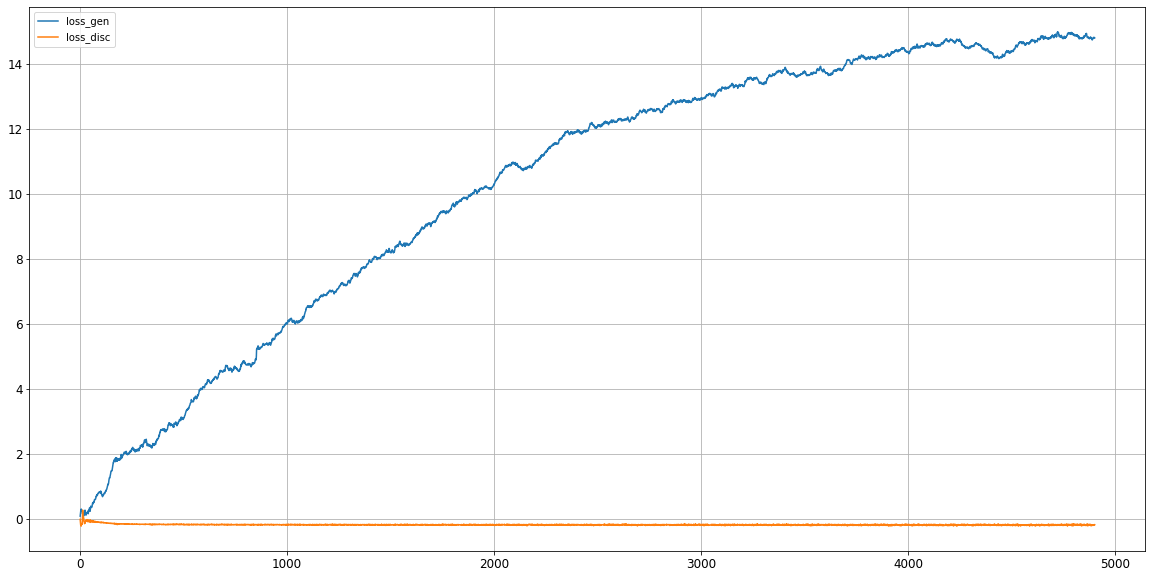

Epoch 5001/10000
critic: -0.189212 - generator: 14.782163 - 2s
disc_numpy -0.13966075
gen_numpy 14.899448
Epoch 5002/10000
critic: -0.216129 - generator: 14.786428 - 2s
disc_numpy -0.2626596
gen_numpy 14.891109
Epoch 5003/10000
critic: -0.178601 - generator: 14.776256 - 2s
disc_numpy -0.21508446
gen_numpy 14.863765
Epoch 5004/10000
critic: -0.189875 - generator: 14.768435 - 2s
disc_numpy -0.19228385
gen_numpy 14.766875
Epoch 5005/10000
critic: -0.187548 - generator: 14.781552 - 2s
disc_numpy -0.15208462
gen_numpy 14.817292
Epoch 5006/10000
critic: -0.200872 - generator: 14.793685 - 2s
disc_numpy -0.26835176
gen_numpy 14.853668
Epoch 5007/10000
critic: -0.190026 - generator: 14.794114 - 2s
disc_numpy -0.16817124
gen_numpy 14.867073
Epoch 5008/10000
critic: -0.168600 - generator: 14.817248 - 2s
disc_numpy -0.14269345
gen_numpy 14.886326
Epoch 5009/10000
critic: -0.204574 - generator: 14.820673 - 2s
disc_numpy -0.22253564
gen_numpy 14.827639
Epoch 5010/10000
critic: -0.172278 - generator:

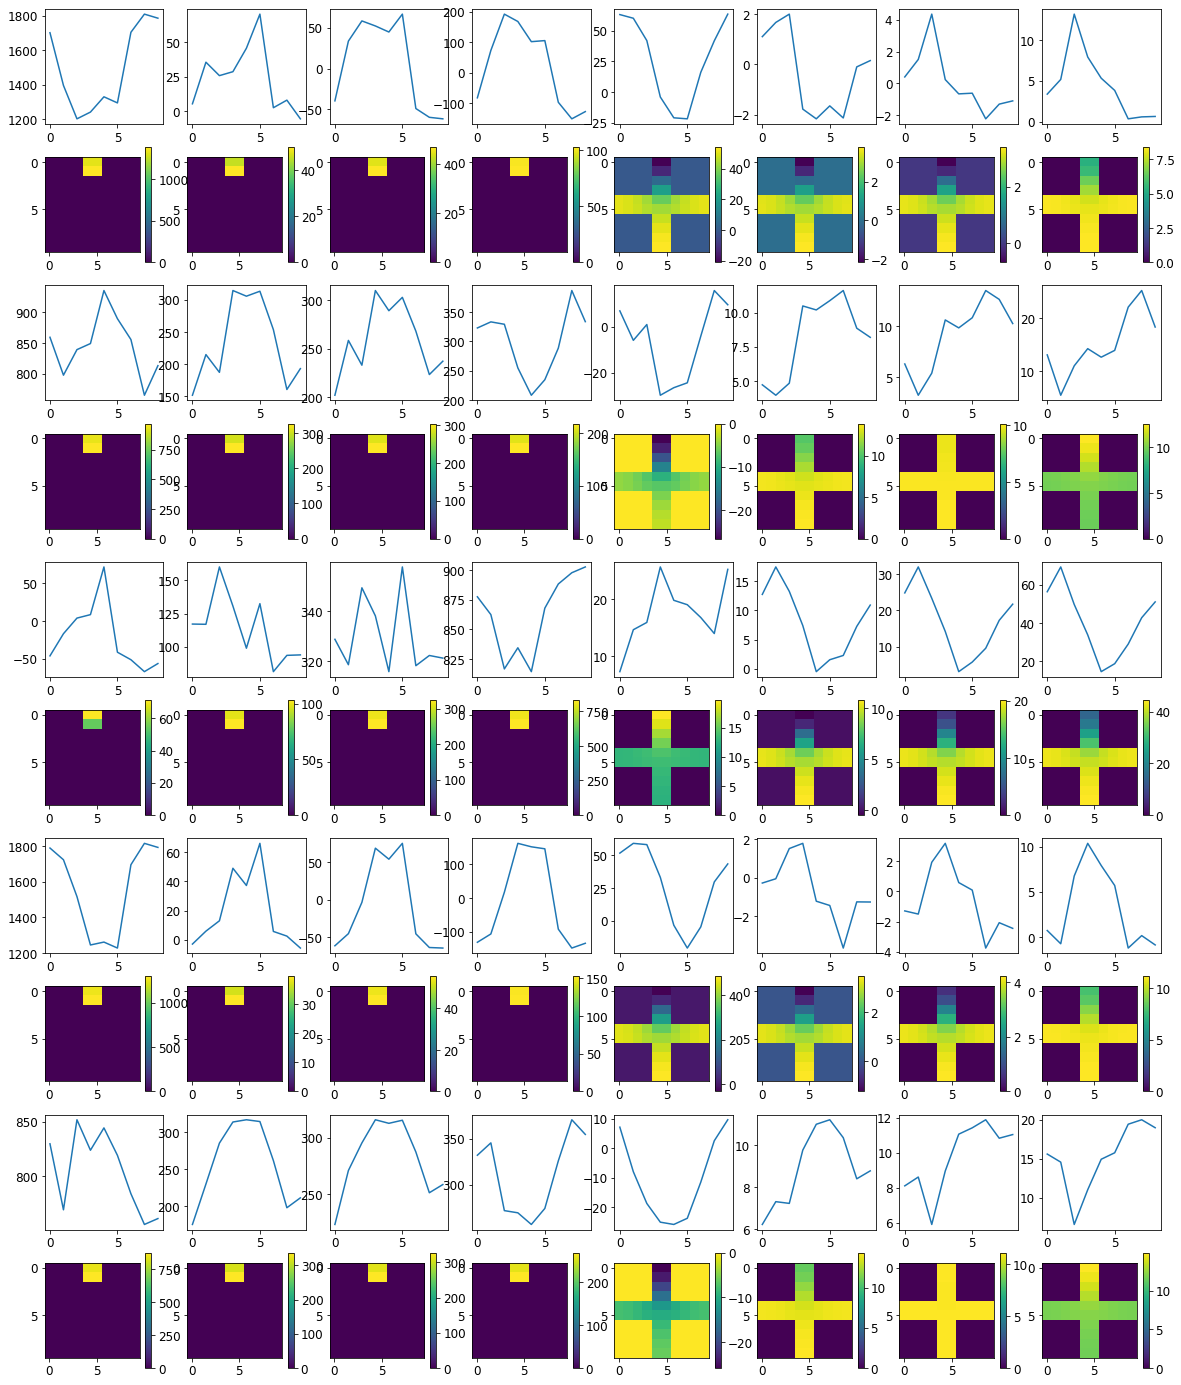

Loss: 


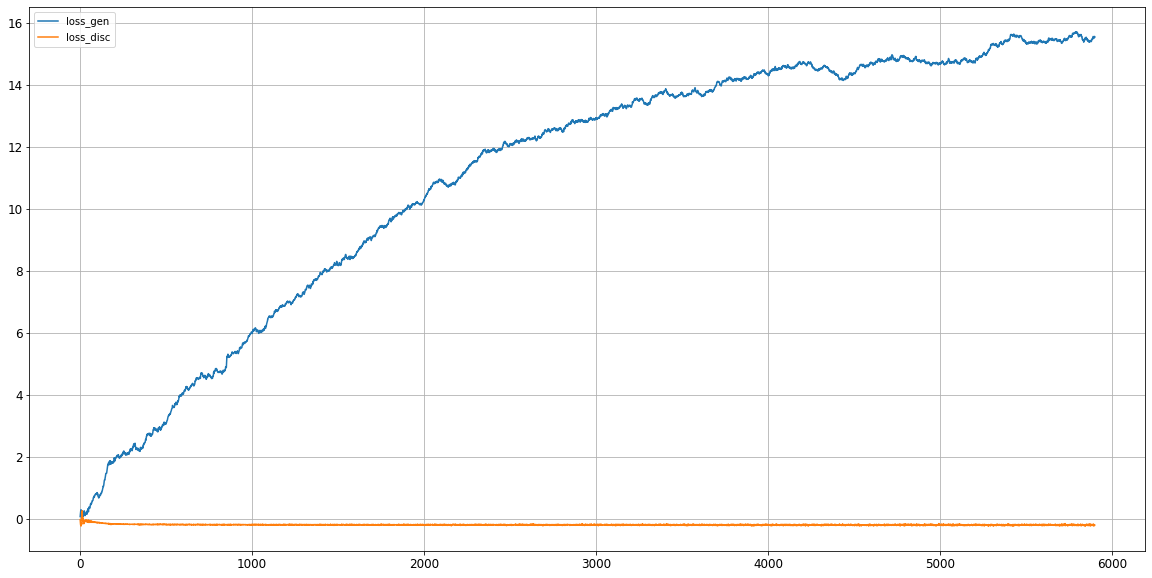

Epoch 6001/10000
critic: -0.182000 - generator: 15.532101 - 2s
disc_numpy -0.16999124
gen_numpy 15.61346
Epoch 6002/10000
critic: -0.184364 - generator: 15.547256 - 2s
disc_numpy -0.2342467
gen_numpy 15.60176
Epoch 6003/10000
critic: -0.186422 - generator: 15.575130 - 2s
disc_numpy -0.20948027
gen_numpy 15.618293
Epoch 6004/10000
critic: -0.194516 - generator: 15.577056 - 2s
disc_numpy -0.14644592
gen_numpy 15.651906
Epoch 6005/10000
critic: -0.167708 - generator: 15.553225 - 2s
disc_numpy -0.17004485
gen_numpy 15.620994
Epoch 6006/10000
critic: -0.214382 - generator: 15.549305 - 2s
disc_numpy -0.11682598
gen_numpy 15.5346575
Epoch 6007/10000
critic: -0.201324 - generator: 15.542164 - 2s
disc_numpy -0.2317515
gen_numpy 15.48065
Epoch 6008/10000
critic: -0.210709 - generator: 15.557795 - 2s
disc_numpy -0.10314627
gen_numpy 15.611885
Epoch 6009/10000
critic: -0.183313 - generator: 15.555734 - 2s
disc_numpy -0.22317389
gen_numpy 15.567889
Epoch 6010/10000
critic: -0.180415 - generator: 15

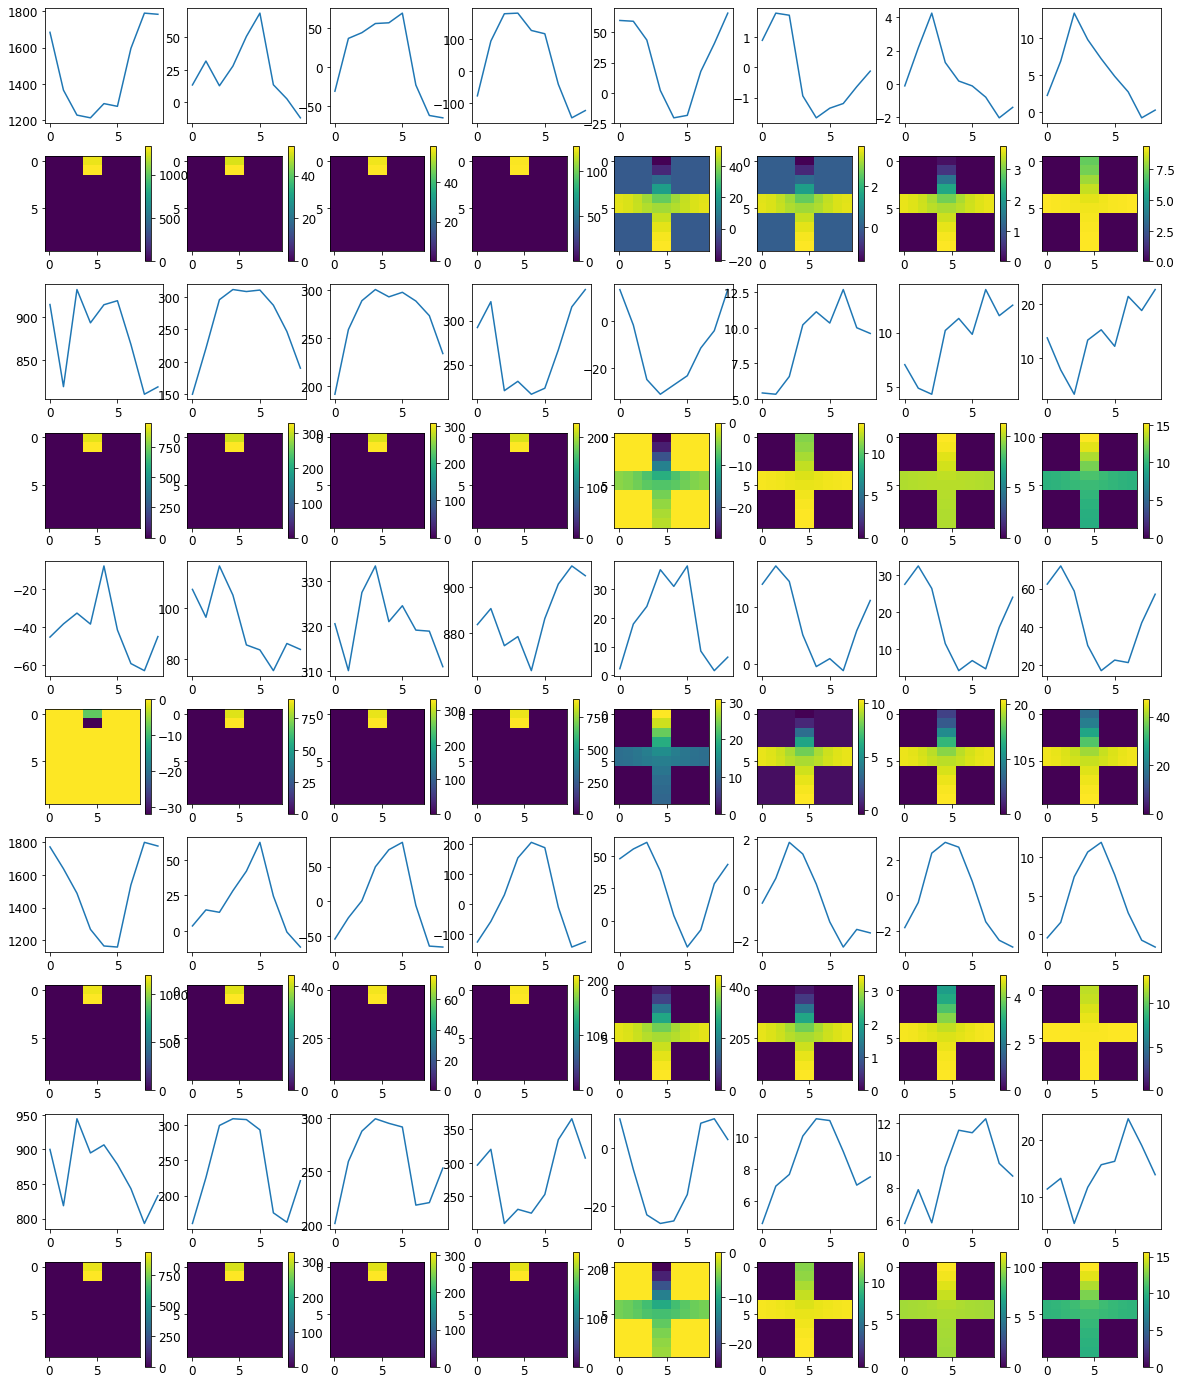

Loss: 


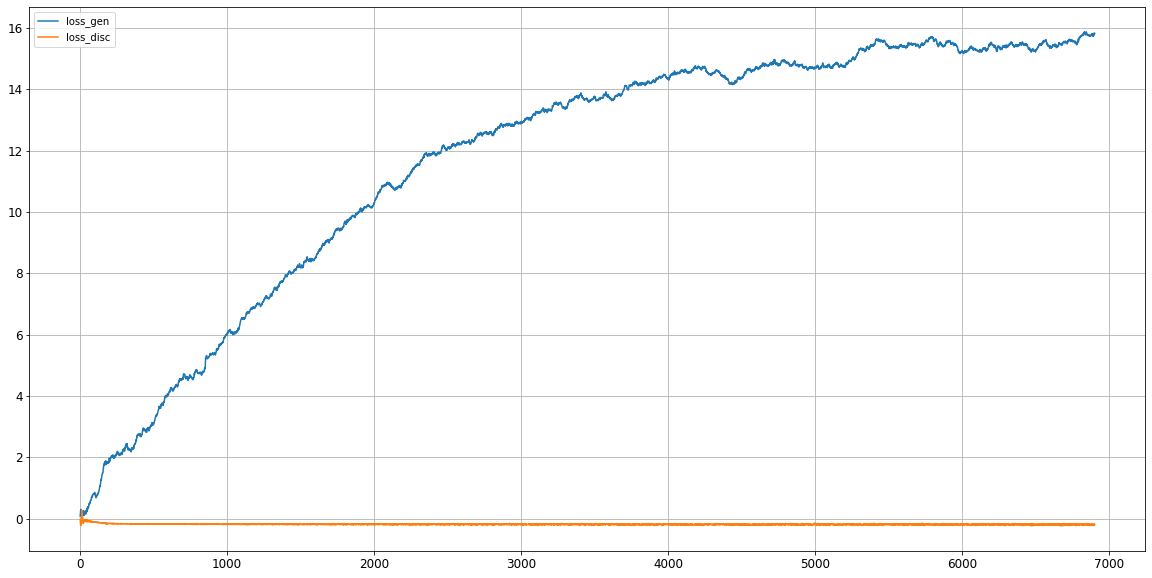

Epoch 7001/10000
critic: -0.194234 - generator: 15.822721 - 2s
disc_numpy -0.22881567
gen_numpy 15.880994
Epoch 7002/10000
critic: -0.182400 - generator: 15.862451 - 2s
disc_numpy -0.1592886
gen_numpy 15.954978
Epoch 7003/10000
critic: -0.174364 - generator: 15.833523 - 2s
disc_numpy -0.1907411
gen_numpy 15.876046
Epoch 7004/10000
critic: -0.186107 - generator: 15.827462 - 2s
disc_numpy -0.20067126
gen_numpy 15.903851
Epoch 7005/10000
critic: -0.204747 - generator: 15.830290 - 2s
disc_numpy -0.2084417
gen_numpy 15.870299
Epoch 7006/10000
critic: -0.195312 - generator: 15.838146 - 2s
disc_numpy -0.23513119
gen_numpy 15.897074
Epoch 7007/10000
critic: -0.182509 - generator: 15.842379 - 2s
disc_numpy -0.15731797
gen_numpy 15.821095
Epoch 7008/10000
critic: -0.166987 - generator: 15.863219 - 2s
disc_numpy -0.20751667
gen_numpy 15.871319
Epoch 7009/10000
critic: -0.185707 - generator: 15.843225 - 2s
disc_numpy -0.19872446
gen_numpy 15.879607
Epoch 7010/10000
critic: -0.181892 - generator: 1

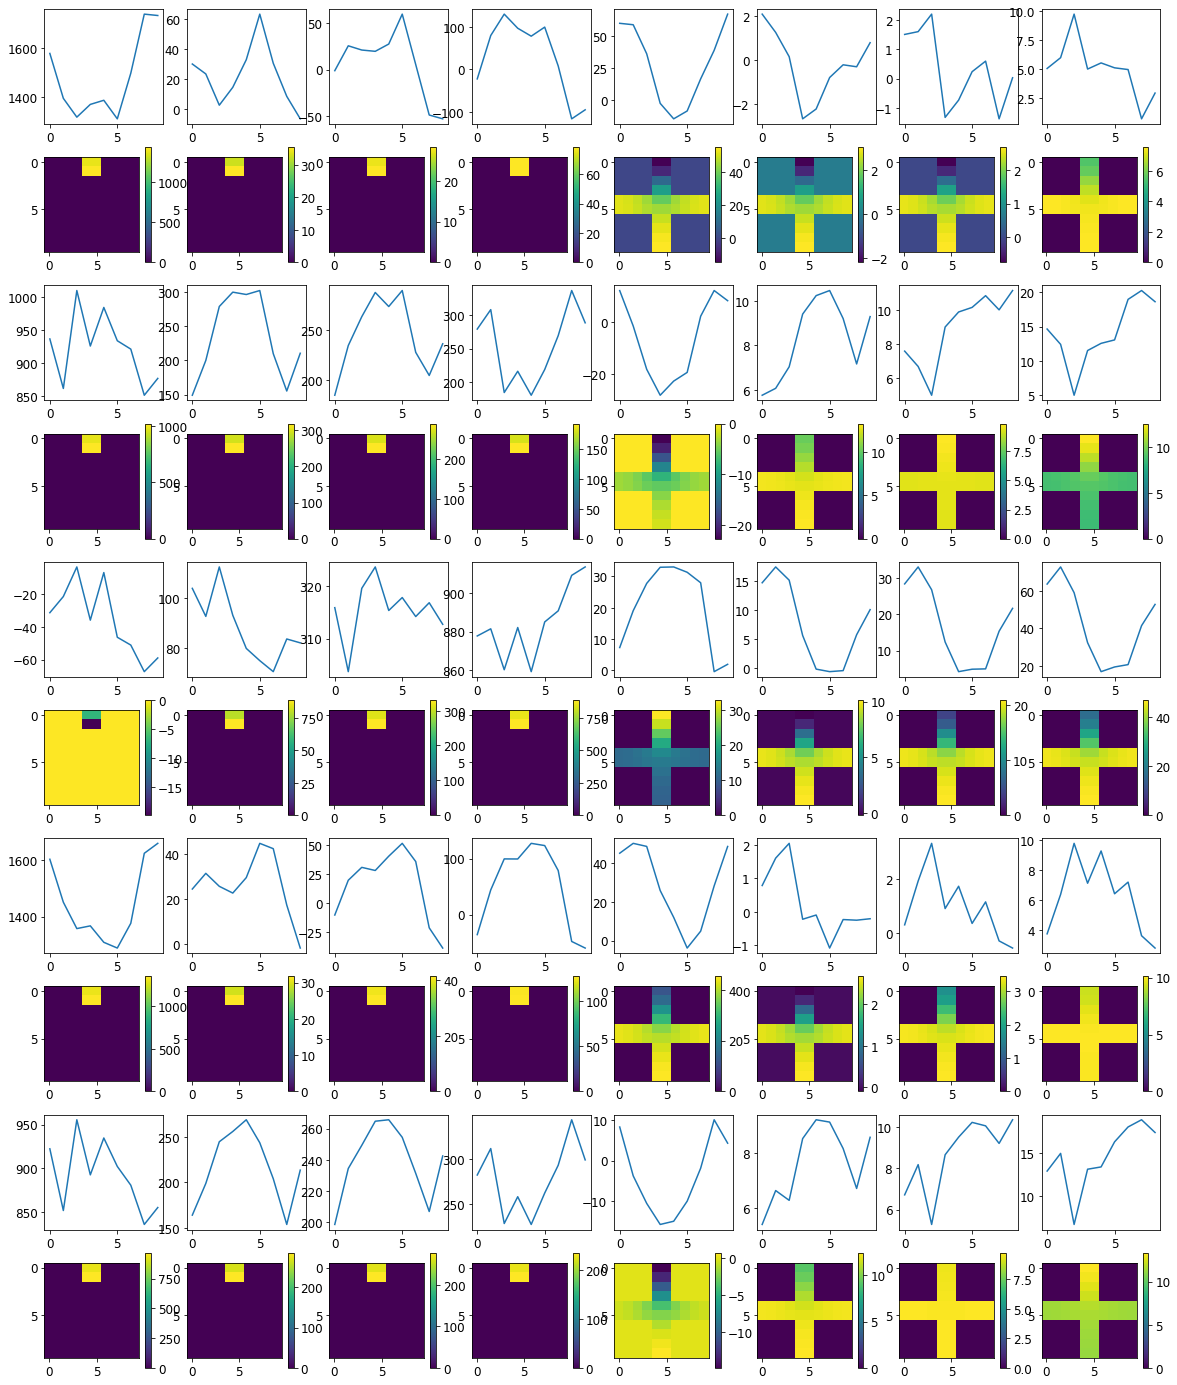

Loss: 


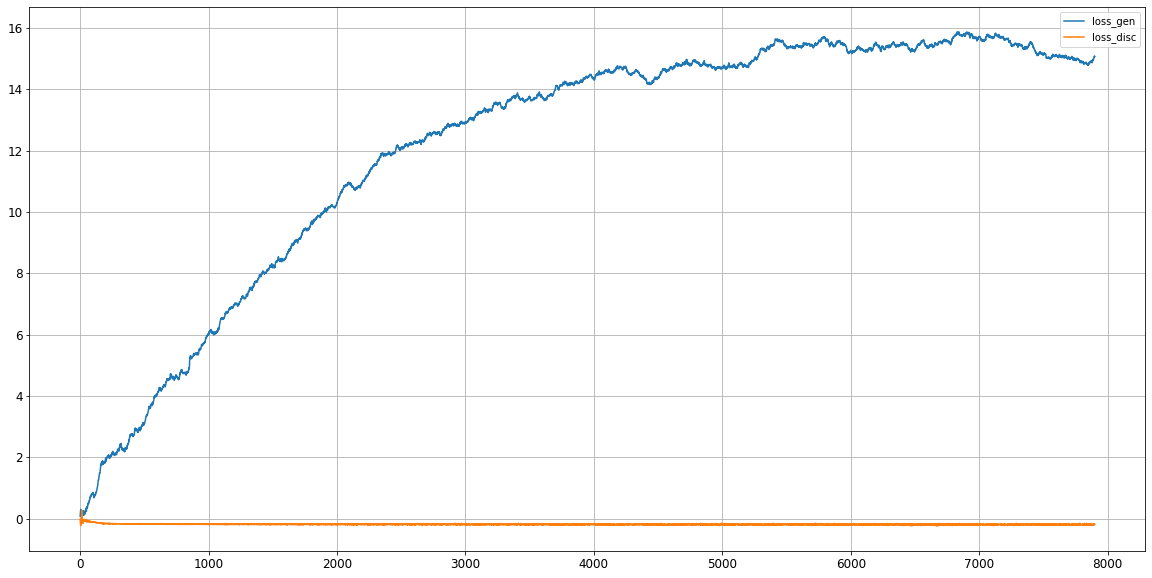

Epoch 8001/10000
critic: -0.212557 - generator: 15.051465 - 2s
disc_numpy -0.26254427
gen_numpy 15.08975
Epoch 8002/10000
critic: -0.192277 - generator: 15.079434 - 2s
disc_numpy -0.21890512
gen_numpy 15.190141
Epoch 8003/10000
critic: -0.203731 - generator: 15.116735 - 2s
disc_numpy -0.1538164
gen_numpy 15.146946
Epoch 8004/10000
critic: -0.211401 - generator: 15.134678 - 2s
disc_numpy -0.24190366
gen_numpy 15.120577
Epoch 8005/10000
critic: -0.213481 - generator: 15.147223 - 2s
disc_numpy -0.2125939
gen_numpy 15.186382
Epoch 8006/10000
critic: -0.185712 - generator: 15.187877 - 2s
disc_numpy -0.25850174
gen_numpy 15.215148
Epoch 8007/10000
critic: -0.181776 - generator: 15.190610 - 2s
disc_numpy -0.06540598
gen_numpy 15.197865
Epoch 8008/10000
critic: -0.185957 - generator: 15.200361 - 2s
disc_numpy -0.12259099
gen_numpy 15.251972
Epoch 8009/10000
critic: -0.198904 - generator: 15.173011 - 2s
disc_numpy -0.15183276
gen_numpy 15.204927
Epoch 8010/10000
critic: -0.178602 - generator: 1

In [ ]:
hist = train(train_dataset, epochs=10000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist[100:])
ax.legend(['loss_gen', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()

In [ ]:
#from tensorflow.keras.models import load_model
import joblib
joblib.dump(scaler, "scaler-tfex.pkl")
gan.save("wgan-tfex.h5")

In [ ]:
np.random.seed(10)
tf.random.set_seed(10)

noise = tf.random.normal(shape=[1, latent_space])
X_generated = scaler.inverse_transform((gan.layers[0].predict(noise).reshape(ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated[X_generated<0.0] = 0.0

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_1D[2930:3020,i*nl*nc+4])
    ax.flatten()[i].set_title(group)

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_generated.reshape(ntimes,len(groups),nl,nc)[0,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[2932,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

In [ ]:
npredict = 5
noise = tf.random.normal(shape=[npredict, latent_space])
X_generated = scaler.inverse_transform((gan.layers[0].predict(noise).reshape(npredict*ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(npredict, ntimes, len(groups)*nl*nc)
fig, ax = plt.subplots(npredict*2,len(groups), figsize=[20,npredict*5])
for j in range(npredict):
    for i, group in enumerate(groups):
        for k in range(0,10,10): 
            ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
    for i, group in enumerate(groups):
        im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
        fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
